In [2]:
import urllib.request
import json
import sqlite3
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\palek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def del_empty(words):
    while '' in words:
        words.remove('')
    return words


def clear(text):
    words = [word for word in re.split(r'[\s.,()—:`;"*&!?\'“”]+', text) 
             if not re.findall('[^А-Яа-я\-]', word)]
    del_empty(words)
    return words


def stopw(words):
    russian_stopwords = stopwords.words("russian")
    for word in words:
        if word in russian_stopwords:
            words.remove(word)
    return words


def lemmat(words):
    mystem = Mystem()
    words = mystem.lemmatize(text.lower())
    return words

In [5]:
def count_years(bdate):
    #
    bdate = datetime.strptime(bdate, '%d.%m.%Y')
    now_date = datetime.now()
    years = now_date.year - bdate.year
    if now_date.month < bdate.month or now_date.month == bdate.month and now_date.day < bdate.day:
        years -= 1
    return years

In [6]:
def read_post(itr):
# itr - номер итерации обращения к стене
    owner_id = '-64474568'
    offset = str(itr * 100)
    v ='5.92'
    access_token = '68f7cc4b68f7cc4b68f7cc4b9c689e0eeb668f768f7cc4b345fbedb73b86a0bd1519d04'
    req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id=%s&v=%s&offset=%s&access_token=%s' %
                                (owner_id, v, offset, access_token)) 
    response = urllib.request.urlopen(req) 
    res = response.read().decode('utf-8')
    data = json.loads(res)
    return data


def read_comment(itr, post_id):
    # itr - номер итерации обращения к комментариям к посту
    owner_id = '-64474568'
    offset = str(itr * 100)
    v ='5.92'
    access_token = '68f7cc4b68f7cc4b68f7cc4b9c689e0eeb668f768f7cc4b345fbedb73b86a0bd1519d04'
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id=%s&post_id=%s&v=%s&offset=%s&access_token=%s' %
                                (owner_id, post_id, v, offset, access_token)) 
    response = urllib.request.urlopen(req) 
    res = response.read().decode('utf-8')
    data = json.loads(res)
    return data


def read_author(auth_id):
    owner_id = '-64474568'
    v ='5.92'
    access_token = '68f7cc4b68f7cc4b68f7cc4b9c689e0eeb668f768f7cc4b345fbedb73b86a0bd1519d04'
    req = urllib.request.Request('https://api.vk.com/method/users.get?user_id=%s&v=%s&access_token=%s&fields=bdate,city,universities,has_photo' %
                                (auth_id, v, access_token)) 
    response = urllib.request.urlopen(req) 
    res = response.read().decode('utf-8')
    data = json.loads(res)
    return data

In [7]:
def make_db():
    os.remove('vk.db')
    conn = sqlite3.connect('vk.db')
    conn.execute('create table if not exists post_inf(post_id text, txt text)')
    conn.execute('create table if not exists comment_inf(post_id text, comment_id text, txt text)')
    conn.execute('create table if not exists auth_post_inf(post_id text, auth_id text, city text, age integer)')
    conn.execute('create table if not exists auth_comment_inf(comment_id text, auth_id text, universities text, has_photo integer)')
    return conn

    
def proc(conn, data, f):
    # добавление постов в базу данных
    for i in range(len(data['response']['items'])):
        try:
            conn.execute('insert into post_inf(post_id, txt) values (?, ?)', 
                     (data['response']['items'][i]['id'], data['response']['items'][i]['text']))
            
            f.write(data['response']['items'][i]['text'])
        
            # добавление информации об авторе поста
            if 'signer_id' in data['response']['items'][i]:
                d_a = read_author(data['response']['items'][i]['signer_id'])
                bd = d_a['response'][0]['bdate']
                conn.execute('insert into auth_post_inf(post_id, auth_id, city, age) values (?, ?, ?, ?)',
                            (data['response']['items'][i]['id'], data['response']['items'][i]['signer_id'],
                            d_a['response'][0]['city']['title'], count_years(d_a['response'][0]['bdate'])))
        
            # добавление комментариев в базу данных
            for j in range(3):
                d = read_comment(j, data['response']['items'][i]['id'])
                for k in range(len(d['response']['items'])):
                    conn.execute('insert into comment_inf(post_id, comment_id, txt) values (?, ?, ?)',
                                (d['response']['items'][k]['post_id'], d['response']['items'][k]['id'],
                                d['response']['items'][k]['text']))
                    f.write(d['response']['items'][k]['text'])

                    d_a = read_author(d['response']['items'][0]['from_id'])
                    if 'universities' not in d_a['response'][0]:
                        uni = None
                    else:
                        uni = d_a['response'][0]['universities'][0]['name']
                    conn.execute('insert into auth_comment_inf(comment_id, auth_id, universities, has_photo) values (?, ?, ?, ?)',
                                (d['response']['items'][k]['id'], d['response']['items'][0]['from_id'], 
                                uni, d_a['response'][0]['has_photo']))

            conn.commit()
        except:
            pass

In [8]:
def connect_db():
    return sqlite3.connect('vk.db')

In [9]:
f = open('plain text', 'w', encoding = 'utf-8')
conn = make_db()
try:
    for i in range(5):
        proc(conn, read_post(i))
finally:
        conn.close()   
f.close()

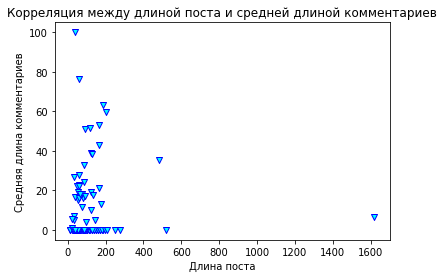

In [9]:
conn = connect_db()

x = []
y = []
posts = conn.execute('select * from post_inf').fetchall()
for post in posts:
    x += [len(clear(post[1]))]
    comments = conn.execute('select * from comment_inf where post_id = ?', (post[0],)).fetchall()
    if len(comments) != 0:
        len_comm = 0
        for comment in comments:
            len_comm += len(clear(comment[2]))
        y += [len_comm / len(comments)]
    else:
        y += [0]
              
plt.scatter(x, y, c='aqua', marker='v', edgecolors='blue')
plt.xlabel('Длина поста')
plt.ylabel('Средняя длина комментариев')
plt.title('Корреляция между длиной поста и средней длиной комментариев')
plt.savefig('kek')

In [10]:
def add_to_dict(par, txt, d):
    if par not in d:
        d[par] = []
    d[par] += [len(txt)]
    return d

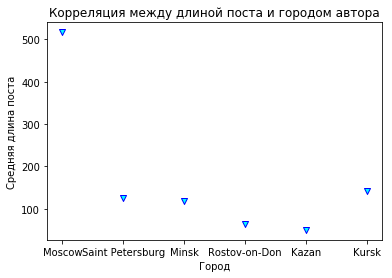

In [11]:
conn = connect_db()

d = {}
authors = conn.execute('select * from auth_post_inf').fetchall()
for author in authors:
    post = conn.execute('select * from post_inf where post_id=?', (author[0],)).fetchone()
    
    add_to_dict(author[2], clear(post[1]), d)
              
plt.scatter(d.keys(), list(map(lambda l: sum(l) / len(l), list(d.values()))), 
            c='aqua', marker='v', edgecolors='blue')
plt.xlabel('Город')
plt.ylabel('Средняя длина поста')
plt.title('Корреляция между длиной поста и городом автора')
plt.savefig('kek')

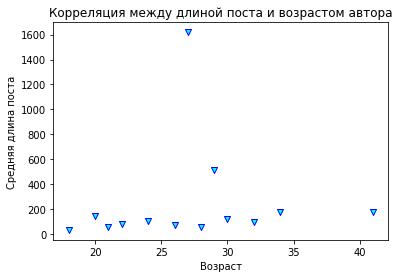

In [12]:
conn = connect_db()

d = {}
authors = conn.execute('select * from auth_post_inf').fetchall()
for author in authors:
    post = conn.execute('select * from post_inf where post_id=?', (author[0],)).fetchone()
    
    add_to_dict(author[3], clear(post[1]), d)
              
plt.scatter(d.keys(), list(map(lambda l: sum(l) / len(l), list(d.values()))), 
            c='aqua', marker='v', edgecolors='blue')
plt.xlabel('Возраст')
plt.ylabel('Средняя длина поста')
plt.title('Корреляция между длиной поста и возрастом автора')
plt.savefig('kek')

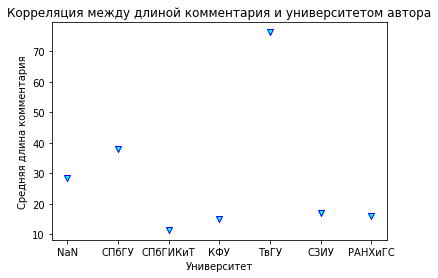

In [27]:
conn = connect_db()

d = {}
authors = conn.execute('select * from auth_comment_inf').fetchall()
for author in authors:
    comment = conn.execute('select * from comment_inf where comment_id=?', (author[0],)).fetchone()
    uni = author[2]
    if uni != None:
        uni = uni.split()
        uni = uni[0]
    else:
        uni = 'NaN'
    add_to_dict(uni, clear(comment[2]), d)
              
plt.scatter(d.keys(), list(map(lambda l: sum(l) / len(l), list(d.values()))), 
            c='aqua', marker='v', edgecolors='blue')
plt.xlabel('Университет')
plt.ylabel('Средняя длина комментария')
plt.title('Корреляция между длиной комментария и университетом автора')
plt.savefig('kek')

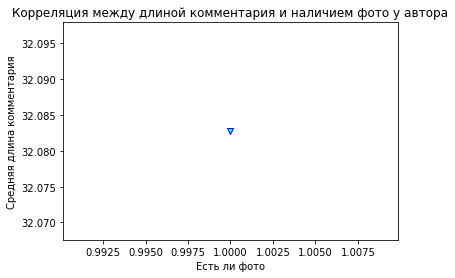

In [30]:
conn = connect_db()

d = {}
authors = conn.execute('select * from auth_comment_inf').fetchall()
for author in authors:
    comment = conn.execute('select * from comment_inf where comment_id=?',
                           (author[0],)).fetchone()
    
    add_to_dict(author[3], clear(comment[2]), d)
              
plt.scatter(d.keys(), list(map(lambda l: sum(l) / len(l), list(d.values()))), 
            c='aqua', marker='v', edgecolors='blue')
plt.xlabel('Есть ли фото')
plt.ylabel('Средняя длина комментария')
plt.title('Корреляция между длиной комментария и наличием фото у автора')
plt.savefig('kek')

In [ ]:
def freq_words(f):
# подсчёт частотности слов в текстах
    text = f.read()
    words = stopw(clear(text))
    d = {}
    
    for word in words:
        if word not in d:
            d[word] = 0
    d[word] += 1
    
    return sorted(d.keys(), key=lambda k: d[k], reverse=True)[:26]


In [ ]:
f = open('plain text', 'r', encoding = 'utf-8')